In [49]:
#!/usr/bin/env python
# encoding: utf-8
'''
@author: ivy
@contact: ivyivyzhao77@gmail.com
@software: PyCharm 2022.3
@file: script_pipeline_validation.py
@time: 2023/3/10 14:54
'''

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

from train._main import *

import numpy as np
import matplotlib.pyplot as plt
import torch.fft as fft
import torch

from torch.autograd import Variable
from models._main import *
from preprocess._utils import *
import torch.nn as nn
import torch.utils.data as Data
import torch
from torch.optim import optimizer


def create_synthetic_data(d, n, ifnoise=False):
    res = np.zeros((d, n))
    assert isinstance(n, int), "wrong number for samples"
    der = []
    for i in range(0, n):
        freq = np.random.uniform(1.0 / d, 5 * 1.0 / d)
        phi = np.random.random()
        step = np.arange(d)
        res[:, i] = np.sin(2 * np.pi * freq * step + phi * (np.pi / 180))
        der.append(2 * np.pi * freq)

    return res, der


def create_dataset(raw_data, raw_der):
    sine_dataset = dict()
    for i, real_data in enumerate(raw_data):
        worm = "worm" + str(i)
        max_time = seq_len
        num_neurons = num_signal
        der = np.array(raw_der[i])
        der = der.reshape(der.shape[0], 1).T
        time_in_seconds = torch.tensor(np.array(np.arange(seq_len)).reshape(seq_len, 1))
        dt = torch.tensor(der)

        num_named = num_neurons
        real_data = torch.tensor(
            real_data, dtype=torch.float64
        )

        smooth_real_data, residual, smooth_residual = smooth_data_preprocess(real_data, "fft")

        for i in range(residual.shape[1]):
            residual[:, i] = residual[:, i] / dt[:, i]

        sine_dataset.update(
            {
                worm: {
                    "dataset": "sine",
                    "worm": worm,
                    "calcium_data": real_data,
                    "smooth_calcium_data": smooth_real_data,
                    "residual_calcium": residual,
                    "residual_smooth_calcium": smooth_residual,
                    "neuron_to_idx": range(0, num_neurons),
                    "idx_to_neuron": range(num_neurons - 1, -1, -1),
                    "max_time": int(max_time),
                    "time_in_seconds": time_in_seconds,
                    "dt": dt,
                    "named_neurons_mask": torch.full((num_neurons,), True),
                    "named_neuron_to_idx": range(0, num_neurons),
                    "idx_to_named_neuron": range(num_neurons - 1, -1, -1),
                    "num_neurons": int(num_neurons),
                    "num_named_neurons": num_named,
                    "num_unknown_neurons": int(num_neurons) - num_named,
                },
            }
        )
    return sine_dataset


class lstm(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE):
        super(lstm, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=LAYERS,
            dropout=DROP_RATE,
            batch_first=True
        )
        self.hidden_out = nn.Linear(HIDDEN_SIZE, INPUT_SIZE)
        self.h_s = None
        self.h_c = None

    def forward(self, x):
        r_out, (h_s, h_c) = self.rnn(x)
        output = self.hidden_out(r_out)
        return output


In [50]:
# Creating signal
seq_len = 3312
num_signal = 302
if_noise = False
num_worms = 6
raw_data = []
raw_der = []
for j in range(num_worms):
    x, der = create_synthetic_data(seq_len, num_signal, if_noise)
    x_torch = Variable(torch.from_numpy(x), requires_grad=False)
    raw_data.append(x_torch)
    raw_der.append(der)

dataset = create_dataset(raw_data, raw_der)
print(dataset["worm0"].keys())

# plt.plot(dataset["worm0"]["calcium_data"][:, 3])
# plt.plot(dataset["worm0"]["residual_calcium"][:, 3])
# plt.legend(["cal", "res"], loc="upper right")
# plt.show()

# config = OmegaConf.load("conf/model.yaml")
# print("Model:", OmegaConf.to_yaml(config), end="\n\n")
# model = get_model(config)
#
# config = OmegaConf.load("conf/train.yaml")
# model, log_dir = train_model(model, dataset, config)

dict_keys(['dataset', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'residual_smooth_calcium', 'neuron_to_idx', 'idx_to_neuron', 'max_time', 'time_in_seconds', 'dt', 'named_neurons_mask', 'named_neuron_to_idx', 'idx_to_named_neuron', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons'])


/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_8879/1094297658.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_data = torch.tensor(


In [51]:
### quick trial on LSTM, model defined above
time_step = 4
# hyperparams
INPUT_SIZE = 302
HIDDEN_SIZE = 302
EPOCH = 50
LR = 0.1  # learning rate
DROP_RATE = 0.2  # drop out
LAYERS = 2  # hidden layer
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
torch.manual_seed(0)

model = lstm(INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

worm_train = []
worm_test = []
for i in range(len(dataset)):
    worm = "worm" + str(i)
    calcium_data = dataset[worm]["calcium_data"].float()
    residual_calcium = dataset[worm]["residual_calcium"].float()
    train_size = int(0.8 * dataset[worm]["max_time"])
    test_size = dataset[worm]["max_time"] - train_size

    train_ca, test_ca = calcium_data.split(train_size, dim=0)
    train_res, test_res = residual_calcium.split(train_size, dim=0)
    train_batch_size = train_size // time_step
    test_batch_size = test_size // time_step

    train_dataset = Data.TensorDataset(train_ca, train_res)
    train_cal = Data.TensorDataset(train_ca, train_ca)
    test_dataset = Data.TensorDataset(test_ca, test_res)
    test_cal = Data.TensorDataset(test_ca, test_ca)
    train_loader = Data.DataLoader(
        dataset=train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
    )
    ca_train_loader = Data.DataLoader(
        dataset=train_cal,
        batch_size=train_batch_size,
        shuffle=True,
    )


    test_loader = Data.DataLoader(
        dataset=test_dataset,
        batch_size=test_batch_size,
        shuffle=True,
    )
    ca_test_loader = Data.DataLoader(
        dataset=test_cal,
        batch_size=test_batch_size,
        shuffle=True,
    )
    worm_train.append(ca_train_loader)
    worm_test.append(ca_train_loader)

Start Training!
--------worm No. 0--------
epoch = 0, train_loss = 0.0000, test_loss = 0.0000
epoch = 1, train_loss = 0.0000, test_loss = 0.0000
epoch = 2, train_loss = 0.0000, test_loss = 0.0000
epoch = 3, train_loss = 0.0000, test_loss = 0.0000
epoch = 4, train_loss = 0.0000, test_loss = 0.0000
epoch = 5, train_loss = 0.0000, test_loss = 0.0000
epoch = 6, train_loss = 0.0000, test_loss = 0.0000
epoch = 7, train_loss = 0.0000, test_loss = 0.0000
epoch = 8, train_loss = 0.0000, test_loss = -0.0000
epoch = 9, train_loss = 0.0000, test_loss = 0.0000
epoch = 10, train_loss = 0.0000, test_loss = -0.0000
epoch = 11, train_loss = -0.0000, test_loss = -0.0000
epoch = 12, train_loss = 0.0000, test_loss = -0.0000
epoch = 13, train_loss = -0.0000, test_loss = -0.0000
epoch = 14, train_loss = -0.0000, test_loss = -0.0000
epoch = 15, train_loss = 0.0000, test_loss = -0.0000
epoch = 16, train_loss = -0.0000, test_loss = -0.0000
epoch = 17, train_loss = -0.0000, test_loss = -0.0000
epoch = 18, train

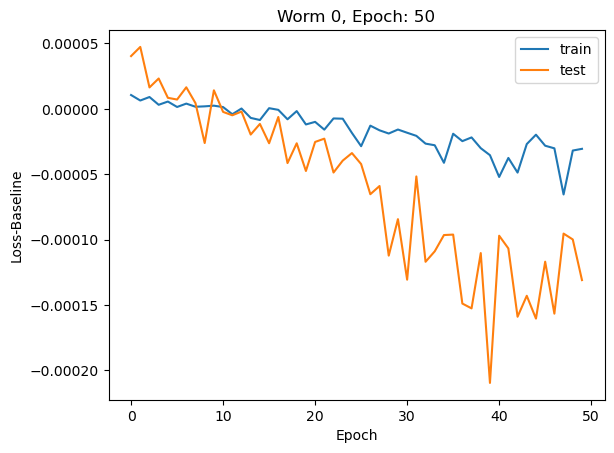

In [55]:
print("Start Training!")
# train
for i in range(len(dataset) - 5):
    print("--------worm " + "No. " + str(i) + "--------")
    train_loader = worm_train[i]
    test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        for X_train, Y_train in train_loader:
            X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_train), Y_train)
            Y_tr = model(X_train)  # Forward pass.
            loss = criterion(Y_tr, Y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
        train_base_loss_history.append(train_base_loss / train_batch_size)
        train_pred_loss_history.append(train_pred_loss / train_batch_size)

        for X_test, Y_test in test_loader:
            X_test, Y_test = X_test.to(DEVICE), Y_test.to(DEVICE)
            optimizer.zero_grad()  # Clear gradients.
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_test), Y_test)
            Y_pred = model(X_test)  # Forward pass.
            loss = criterion(Y_pred, Y_test)
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
        test_base_loss_history.append(test_base_loss / test_batch_size)
        test_pred_loss_history.append(test_pred_loss / test_batch_size)

        print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e,
                                                                 train_pred_loss_history[-1] - train_base_loss_history[
                                                                     -1],
                                                                 test_pred_loss_history[-1] - test_base_loss_history[
                                                                     -1]))

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(i) + ", Epoch: " + str(EPOCH))
    plt.show()

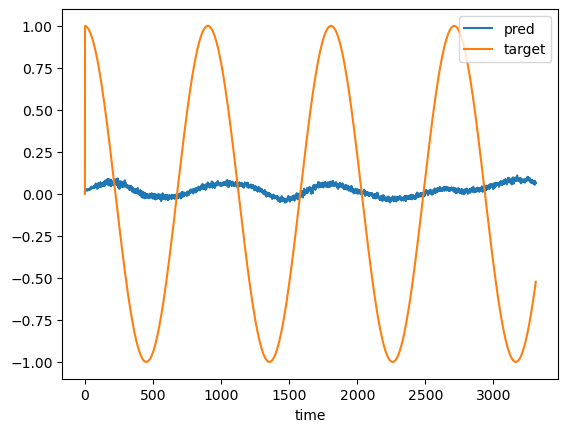

In [48]:
# prediction residual visualization (train on calcium - residual)
calcium_data = dataset["worm0"]["calcium_data"].float()
residual_calcium = dataset["worm0"]["residual_calcium"].float()
prediction = model(calcium_data)
plt.plot(prediction[:, 0].detach().numpy())
plt.plot(residual_calcium[:, 0])

plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

In [ ]:
# prediction calcium visualization (train on calcium - calcium)
calcium_data = dataset["worm0"]["calcium_data"].float()
target = calcium_data
prediction = model(calcium_data)
plt.plot(prediction[:, 0].detach().numpy())
plt.plot(target[:, 0])

plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()